In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

### Change the currency

UPDATE order_payments
SET payment_value = payment_value / 535;

UPDATE order_items
SET price = price / 535,
	freight_value = freight_value / 535;


## The payment method that spend the most

SELECT SUM(payment_value)/COUNT(*) AS avg_order_value,
	COUNT(*) AS num_transactions,
	STDDEV(payment_value::numeric) AS std,
	payment_type
FROM order_payments
GROUP BY payment_type;

In [4]:
def mean_ci(mean, n_sample, std, name, do_return = False, alpha=0.05):
    st_err = std / np.sqrt(n_sample)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    low_bound = round(mean - st_err*z_crit, 3)
    high_bound = round(mean + st_err*z_crit, 3)

    if do_return:
        return low_bound, high_bound
    else:
        print(f'Mean of {name}: {low_bound} — {round(mean, 3)} — {high_bound}')


In [5]:
#Th:
mean_bol = 27.10
n_bol = 19784
std_bol = 39.92

mean_cc = 30.52
n_cc = 76795
std_cc = 41.52

mean_dc = 26.64
n_dc = 1529
std_dc = 45.94

mean_vc = 12.27
n_vc = 5775
std_vc = 21.59

#Calculations
mean_ci(mean_bol, n_bol, std_bol, name='Boleto',alpha=0.05)
mean_ci(mean_cc, n_cc, std_cc, name='Credit C.',alpha=0.05)
mean_ci(mean_dc, n_dc, std_dc, name='Debit C.',alpha=0.05)
mean_ci(mean_vc, n_vc, std_vc, name='Voucher',alpha=0.05)

Mean of Boleto: 26.544 — 27.1 — 27.656
Mean of Credit C.: 30.226 — 30.52 — 30.814
Mean of Debit C.: 24.337 — 26.64 — 28.943
Mean of Voucher: 11.713 — 12.27 — 12.827


In [6]:
print(f'Credit c. is {round(100*(30.226 - 27.656)/27.656, 1)}% more than boleto')
print(f'Credit c. is {round(100*(30.226 - 12.827)/12.827, 1)}% more than voucher')

Credit c. is 9.3% more than boleto
Credit c. is 135.6% more than voucher


### Findings:

Customers that use credit card spend 9,3% more than customers that use boleto... and 135.6% more than customers who use voucher.

## Brazilian state more prone to credit_card

WITH freq_table_all_cities AS (
	SELECT COUNT(*) AS frequency,
		customers.customer_state,
		payments.payment_type
	FROM orders
	LEFT JOIN customers ON orders.customer_id = customers.customer_id
	LEFT JOIN order_payments as payments ON payments.order_id = orders.order_id
	WHERE orders.order_status = 'delivered'
		AND payments.payment_type IN ('credit_card', 'boleto')
	GROUP BY customers.customer_state, payments.payment_type
	ORDER BY customers.customer_state
),

freq_table AS(
	SELECT *,
		SUM(frequency) OVER (PARTITION BY customer_state) AS tot_transactions
	FROM freq_table_all_cities
)

SELECT *
FROM freq_table
WHERE tot_transactions > 200;

## Satisfaction vs Delay delivery

WITH review_vs_delivery AS(
	SELECT
		EXTRACT(DAY FROM orders.order_estimated_delivery_date - orders.order_delivered_customer_date) AS days_in_advance,
		reviews.review_score
	FROM orders
	JOIN order_reviews AS reviews ON reviews.order_id = orders.order_id
	WHERE (orders.order_estimated_delivery_date - orders.order_delivered_customer_date) IS NOT NULL
)

SELECT
    CASE
        WHEN days_in_advance > 0 THEN 'early'
        WHEN days_in_advance = 0 THEN 'on_time'
        ELSE 'delay'
    END AS delivery_status,
	STDDEV(review_score) as std,
	COUNT(*) AS frequency,
    ROUND(AVG(review_score),2) AS average_review_score
FROM 
    review_vs_delivery
GROUP BY 
    CASE
        WHEN days_in_advance > 0 THEN 'early'
        WHEN days_in_advance = 0 THEN 'on_time'
        ELSE 'delay'
    END;

In [7]:
n_on_time = 2718
mean_on_time = 4.11
std_on_time = 1.2229379667062870

n_early = 86527
mean_early = 4.30
std_early = 1.1443707624508323

n_delay = 6362
mean_delay = 2.27
std_delay = 1.5708429336836291

mean_ci(mean_on_time, n_on_time, std_on_time, 'ON TIME')
mean_ci(mean_early, n_early, std_early, 'EARLY')
mean_ci(mean_delay, n_delay, std_delay, 'DELAY')

Mean of ON TIME: 4.064 — 4.11 — 4.156
Mean of EARLY: 4.292 — 4.3 — 4.308
Mean of DELAY: 2.231 — 2.27 — 2.309


In [8]:
print(f'Early vs. On time: +{round(100* (4.29-4.156)/4.156,1)}% satisfaction')
print(f'Early vs. Delay: +{round(100* (4.292-2.309)/2.309, 1)}% satisfaction')
print(f'On time vs. Delay: +{round(100* (4.064-2.309)/2.309, 1)}% satisfaction')

Early vs. On time: +3.2% satisfaction
Early vs. Delay: +85.9% satisfaction
On time vs. Delay: +76.0% satisfaction


WITH review_vs_delivery AS(
	SELECT
		EXTRACT(DAY FROM orders.order_estimated_delivery_date - orders.order_delivered_customer_date) AS days_in_advance,
		reviews.review_score
	FROM orders
	JOIN order_reviews AS reviews ON reviews.order_id = orders.order_id
	WHERE (orders.order_estimated_delivery_date - orders.order_delivered_customer_date) IS NOT NULL
),

reviews_delivery_bin AS(
	SELECT
		*,
		width_bucket(days_in_advance, -20, 20, 20) AS bin
	FROM review_vs_delivery
)

SELECT
	bin,
	MAX(days_in_advance) AS high_bound,
	MIN(days_in_advance) AS low_bound,
	AVG(review_score) AS avg_stars
FROM reviews_delivery_bin
GROUP BY bin
ORDER BY bin;

In [9]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\ecom_brazil\4 tableau\review_score_vs_delivery.csv')
df.head()

,bin,high_bound,low_bound,avg_stars
0,0,-21,-188,1.768725
1,1,-19,-20,1.587500
2,2,-17,-18,1.672840
3,3,-15,-16,1.696000
4,4,-13,-14,1.654494


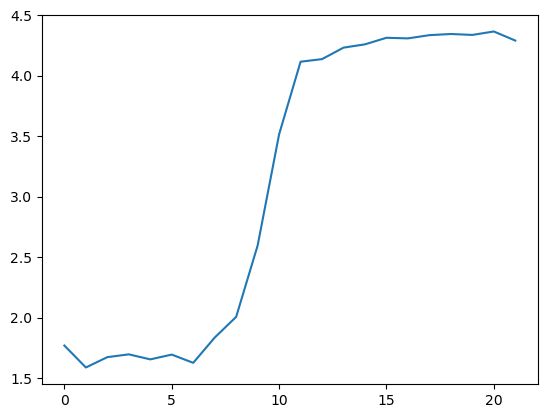

In [10]:
plt.plot(df['bin'], df['avg_stars'])

## Brazil and the tendency to buy locally

SELECT
	CASE
		 WHEN sellers.seller_city = customers.customer_city THEN 'km 0'
		 WHEN sellers.seller_state = customers.customer_state THEN 'local'
		 ELSE 'not local'
	END,
	COUNT(*) AS frequency
FROM orders
LEFT JOIN order_items AS items ON items.order_id = orders.order_id
JOIN customers ON customers.customer_id = orders.customer_id
JOIN sellers ON sellers.seller_id = items.seller_id
GROUP BY CASE
		 	WHEN sellers.seller_city = customers.customer_city THEN 'km 0'
			WHEN sellers.seller_state = customers.customer_state THEN 'local'
		 	ELSE 'not local'
		 END;

WITH distances AS(
    SELECT
        ACOS(
            GREATEST(
                LEAST(
                    SIN(RADIANS(geo_sellers.geolocation_lat)) * SIN(RADIANS(geo_cust.geolocation_lat)) +
                    COS(RADIANS(geo_sellers.geolocation_lat)) * COS(RADIANS(geo_cust.geolocation_lat)) *
                    COS(RADIANS(geo_cust.geolocation_lng) - RADIANS(geo_sellers.geolocation_lng)),
                    1
                ),
                -1
            )
        ) * 6371 AS distance
    FROM orders
    LEFT JOIN order_items AS items ON items.order_id = orders.order_id
    JOIN customers ON customers.customer_id = orders.customer_id
    JOIN sellers ON sellers.seller_id = items.seller_id
    JOIN geolocation as geo_sellers ON geo_sellers.geolocation_zip_code_prefix = sellers.seller_zip_code_prefix
    JOIN geolocation as geo_cust ON geo_cust.geolocation_zip_code_prefix = customers.customer_zip_code_prefix
)

SELECT
    AVG(distance) AS avg_distance,
    PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY distance) AS median_distance
FROM distances;

## State with the highest order value

SELECT
	customers.customer_state AS state,
	ROUND(AVG(payment.payment_value::NUMERIC), 2) AS avg_order_value,
	ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY payment.payment_value::NUMERIC)::NUMERIC, 2) AS median_order_value,
	ROUND(STDDEV(payment.payment_value::NUMERIC), 3) AS std,
	COUNT(*)
FROM orders
JOIN customers ON customers.customer_id = orders.customer_id
JOIN order_payments AS payment ON payment.order_id = orders.order_id
WHERE payment.payment_sequential = 1
GROUP BY customers.customer_state
ORDER BY AVG(payment.payment_value::NUMERIC) DESC;

In [11]:
df_states = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\ecom_brazil\4 tableau\order_value_vs_state.csv')
df_states.head()

,state,avg_order_value,median_order_value,std,count
0,PB,47.72,28.46,72.114,536
1,RO,44.55,29.39,57.684,253
2,AP,44.24,27.13,52.143,68
3,AC,44.00,29.58,40.506,81
4,AL,43.05,25.65,51.655,413


In [12]:
df_states.head()

,state,avg_order_value,median_order_value,std,count
0,PB,47.72,28.46,72.114,536
1,RO,44.55,29.39,57.684,253
2,AP,44.24,27.13,52.143,68
3,AC,44.00,29.58,40.506,81
4,AL,43.05,25.65,51.655,413


In [13]:
df_states['bounds'] = df_states.apply(
    lambda row: mean_ci(row['avg_order_value'], row['count'], row['std'], row['state'], do_return=True),
    axis=1
)

df_states['low_bound'] = df_states['bounds'].str[0]
df_states['high_bound'] = df_states['bounds'].str[1]

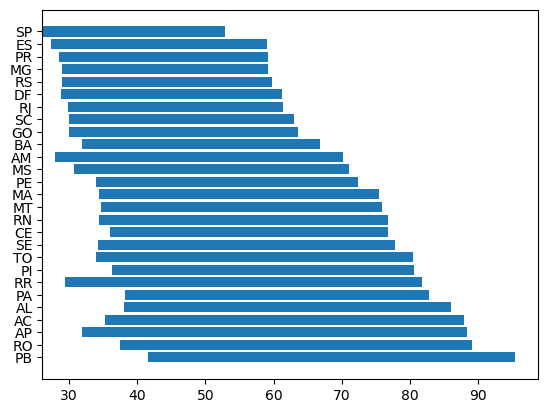

In [14]:
plt.barh(df_states['state'], df_states['high_bound'], left=df_states['low_bound'])
plt.show()

There's not enough statistical evidence that the avg order value of a state is higher
than the one of the other states.
Probably, it's better to invest in the state with the cheapest conversion
rather than the state with the highest avg order value.

## State with the most recurring customers

**Yealy value by state**

WITH life_time_table AS(
	SELECT
		EXTRACT(DAYS FROM (SELECT MAX(order_purchase_timestamp) FROM orders) - MIN(orders.order_purchase_timestamp)) AS lt_days,
		customers.customer_unique_id AS id,
		customers.customer_state AS state,
		SUM(payments.payment_value) AS lt_spent
	FROM orders
	JOIN customers ON customers.customer_id = orders.customer_id
	JOIN order_payments AS payments ON payments.order_id = orders.order_id
	WHERE payments.payment_sequential = 1
	GROUP BY customers.customer_unique_id, customers.customer_state
)

SELECT
	state,
	ROUND(STDDEV(lt_spent::NUMERIC * 365 / (CASE
		WHEN lt_days < 365 THEN 365
		ELSE lt_days END)),2) as std,
	ROUND(AVG(lt_spent::NUMERIC * 365 / (CASE
		WHEN lt_days < 365 THEN 365
		ELSE lt_days END)),2) as yearly_value,
	COUNT(*) AS size
FROM life_time_table
GROUP BY state;

**Proportion of recurring customers by state**

WITH recurring_tab AS(
	SELECT
		customers.customer_state AS state,
		COUNT(*) AS num_orders,
		CASE
			WHEN COUNT(*)>1 THEN 1
			ELSE 0
		END AS is_recurring
	FROM orders
	JOIN customers ON customers.customer_id = orders.customer_id
	GROUP BY customers.customer_state, customers.customer_unique_id
)

SELECT
	state,
	COUNT(*) AS size,
	SUM(is_recurring) AS recurring_size,
	ROUND(SUM(is_recurring)::NUMERIC/COUNT(*)::NUMERIC, 4) AS pi
FROM recurring_tab
GROUP BY state;

In [15]:
def proportion_ci(sample_pi, sample_size, name, alpha=0.05, do_return=False):
    st_err = np.sqrt(sample_pi*(1-sample_pi)/sample_size)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    low_bound = round(sample_pi - st_err*z_crit, 3)
    high_bound = round(sample_pi + st_err*z_crit, 3)

    if do_return:
        return low_bound, high_bound
    else:
        print(f'Mean of {name}: {low_bound} — {round(sample_pi, 3)} — {high_bound}')


In [17]:
df_yearly_value = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\ecom_brazil\4 tableau\recurring_pi_by_state.csv')
df_yearly_value.head()

,state,size,recurring_size,pi
0,RR,45,1,0.0222
1,MG,11259,338,0.0300
2,MT,876,29,0.0331
3,CE,1313,22,0.0168
4,AC,77,4,0.0519


In [20]:
df_yearly_value['low_bound'] = df_yearly_value.apply(
        lambda x: proportion_ci(x['pi'], x['size'], x['state'], do_return=True), axis=1
    ).str[0]
df_yearly_value['high_bound'] = df_yearly_value.apply(
        lambda x: proportion_ci(x['pi'], x['size'], x['state'], do_return=True), axis=1
    ).str[1]

In [22]:
mask = df_yearly_value['low_bound'] < 0
df_yearly_value.loc[mask, 'low_bound'] = 0

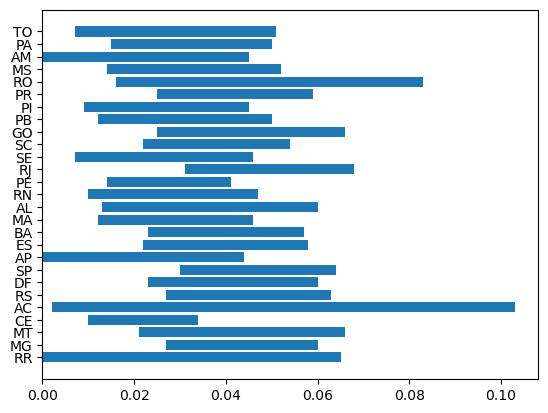

In [23]:
plt.barh(df_yearly_value['state'], df_yearly_value['high_bound'], left=df_yearly_value['low_bound'])
plt.show()

There's no statistical evidence to say that a state has a higher proportion of recurring customers than other states. Hence, the best thing to do in this case is to go for the state with the most current customer or with the state with the cheapest conversion rate.

## Most sold categories

SELECT
	translat.product_category_name_english AS category,
	COUNT(*) AS frequency
FROM products
JOIN product_category_name_translation AS translat ON translat.product_category_name = products.product_category_name
JOIN order_items AS items ON items.product_id = products.product_id
GROUP BY translat.product_category_name_english
ORDER BY COUNT(*) DESC;

## Orders with just one category

WITH sold_togheter AS(
	SELECT
		translat.product_category_name_english AS category,
		items.product_id AS product_id,
		items.order_id AS order_id,
		MAX(items.order_item_id) OVER (PARTITION BY items.order_id) AS num_items
	FROM products
	JOIN product_category_name_translation AS translat ON translat.product_category_name = products.product_category_name
	JOIN order_items AS items ON items.product_id = products.product_id
	ORDER BY items.order_item_id DESC
),

categories_sold_togheter AS(
	SELECT
		order_id,
		category,
		num_items,
		COUNT(*) AS num_category
	FROM sold_togheter
	WHERE num_items > 1
	GROUP BY order_id, category, num_items
	ORDER BY num_items DESC
)

SELECT
	SUM(CASE WHEN num_items=num_category THEN 1 ELSE 0 END) AS one_cat_orders,
	COUNT(DISTINCT order_id) as tot_orders
FROM categories_sold_togheter;

**Findings:**
The vast majority of orders (with more than 1 product) in Brazil are within the same product category.

## Most sold togheter products